In [ ]:
# demo: loads file with all messages (CSTARTTIME, CSENDERENDPOINTID, ymdhm )
# show some charts, anomaly detection with LSTM autoencoders

In [1]:
import dfBasics
import common
import encoder
import pfAdapt
import charts
import anomaly

Setup Complete


2022-08-21 15:54:15.124709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-21 15:54:15.124745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Setup Complete


In [2]:
import pandas as pd
from pyspark.sql import functions

In [5]:
sparkSession = dfBasics.getSparkSession()
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/CSENDERENDPOINTID/CSENDERENDPOINTID_9.parquet')
pfall = df.toPandas()

In [18]:
sparkSession = dfBasics.getSparkSession()
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/sla/sla_1580137124017.parquet')
pfall = df.toPandas()

In [4]:
#pfall = pd.read_parquet('/tmp/msgsenders_0702.parquet', engine='fastparquet')
#pfall = pd.read_parquet('/tmp/sla_1580137124017.parquet', engine='pyarrow')
pfall = pd.read_parquet('/tmp/sla_1580137124017.parquet', engine='pyarrow')

#pfall = pd.read_parquet('/tmp/sla_1580199488133.parquet', engine='pyarrow')

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/sla_1580137124017.parquet'

In [ ]:
#adddatecolumns(pfall,pfall,'CSTARTTIME')
#pfall.dtypes
#pfall.dtypes
#!ls -l /tmp/sla_*.parquet

In [6]:
from datetime import time
import datetime as dt
import calendar
import pytz
de = pytz.timezone('Europe/Berlin')

# long timestamp
def date(x):
    return  dt.datetime.fromtimestamp(float(x) / 1e3, tz=de)


def adddatecolumns(data,pf,column) :
    data['year'] = pf[column].apply(lambda x: date(x).date().year)
    data['month'] = pf[column].apply(lambda x: date(x).date().month)
    data['day'] = pf[column].apply(lambda x: date(x).date().day)
    data['hour'] = pf[column].apply(lambda x: date(x).time().hour)
    data['minute'] = pf[column].apply(lambda x: date(x).time().minute)
    #data['second'] = pf[column].apply(lambda x: x.time().second)
    #data['microsecond'] = pf[column].apply(lambda x: x.time().microsecond)

def converttimestampcolumnn(pf,tsc) :
    pf[tsc] = pf[tsc].apply(lambda x: dt.datetime.fromtimestamp(float(x) / 1e3))

In [7]:
## Setup charts
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

def get_ym_string(a,b) :
    return a + "-" + b
    #return a.join(["-",b]) 

def get_ym(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    return a,b

def get_ymd(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    return a,b,c

def get_ymd_string(a,b,c) :
    return a + "-" + b + "-" + c 

def get_ymdh(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    d = mdcountsall.index.get_level_values(3).astype(str)
    return a,b,c,d

def get_ymdh_string(a,b,c,d) :
    return a + "-" + b + "-" + c + "-" + d

def createData_ym(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month'])['year'].count()    
    a,b = get_ym(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ym_string(a,b)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def createData(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day','hour'])['year'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['outcome'] =  mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int)

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    return data2

def createData_ymd(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day'])['year'].count()    
    a,b,c = get_ymd(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymd_string(a,b,c)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def label(graph,skip,rot) :
    for ind, label in enumerate(graph.get_xticklabels()):
        if ind % skip == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(rot)
        else:
            label.set_visible(False)

def createBarplot(md=None,fx=24,fy=12,fontscale=3.0,title="") :
    sns.set(style='whitegrid', palette='muted', font_scale=fontscale)
    plt.figure(figsize=(fx,fy))
    plt.title(title)
    ax = sns.barplot(x=md['date'], y=md['outcome'], data=md)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=75 )
    plt.tight_layout()
    plt.show()
    return ax

## heatmap
def createHeatmap(piv,title="") :
    plt.figure(figsize=(24,8))
    plt.title(title)
    ax = sns.heatmap(piv, square=True)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
    plt.tight_layout()
    plt.show()
    return ax

Setup Complete


In [10]:
pfall

,CGLOBALMESSAGEID,year,month,day,hour
0,6878249240966155692,2020,1,15,5
1,-3549930604559515972,2020,1,15,5
2,7294079960648046876,2020,1,15,7
3,4593600892465465186,2020,1,15,9
4,-1466978904100060073,2020,1,15,10
...,...,...,...,...,...
1782420,-7897740044678644349,2020,4,5,22
1782421,-6783699335817719085,2020,4,5,22
1782422,3176671547071877123,2020,4,5,22
1782423,-541979808772834438,2020,4,5,22


# Charts

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.2-src.zip/py4j/clientserver.py", line 480, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.2-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.2-src.zip/py4j/clientserver.py", line 503, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


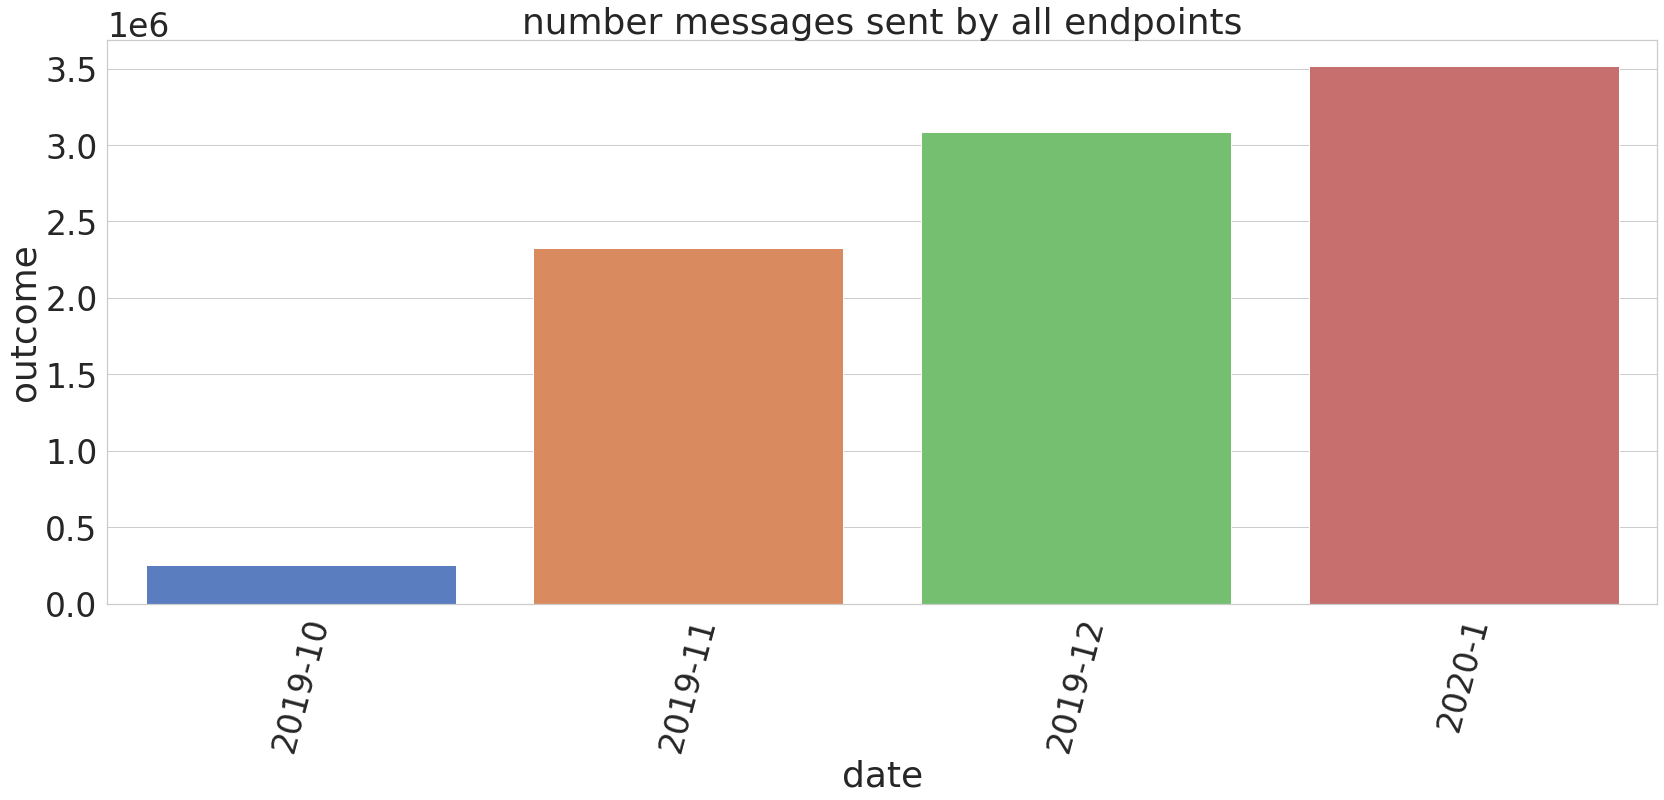

In [20]:
md = createData_ym(pfall,0)
ax=createBarplot(md,24,12,3.0,title="number messages sent by all endpoints")
#label(ax,1000,90)

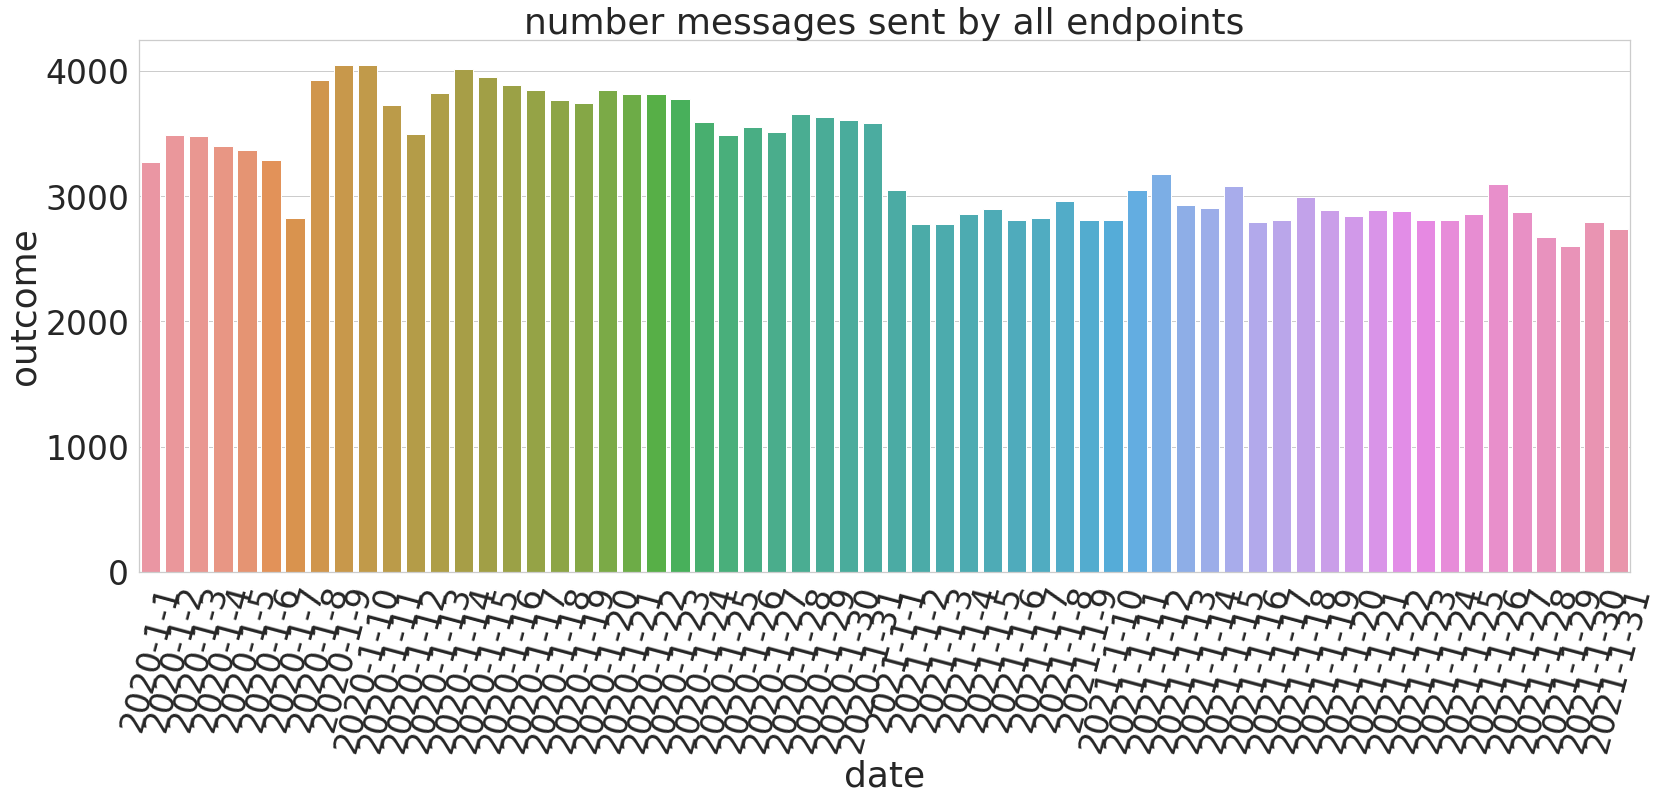

In [9]:
md = createData_ymd(pfall,1)
ax=createBarplot(md,fx=24,fy=12,fontscale=3.0,title="number messages sent by all endpoints")
label(ax,1000,90)


In [27]:
import ipywidgets as widgets
from IPython.display import display, clear_output
style = {'description_width': '250px'}
layout = {'width': '500px'}

def createHeatmapPfall(pfall=pfall,sender='all',month=1):
    data2 = createData(pfall,month)
    piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
    #titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category + " so far = " + str(topsender.iloc[7]['outcome']) + " , month: " + str(month) 
    #titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category  + " month: " + str(month) 
    titlestring ="number messages 2020-" + str(month) + " sender: " + sender
    sns.set(style='whitegrid', palette='muted', font_scale=1.2)
    createHeatmap(piv, titlestring)
    

def monthw_on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            with out:
                clear_output()
                createHeatmapPfall(pfall=pfall,sender='all',month=1)

            
options = [1,2,3,4,5,6,7,8,9,10,11,12]
monthw = widgets.Dropdown(options=options,  description='month', value = 1,style=style, layout=layout)
monthw.observe(monthw_on_change,'value') 
display(monthw)
out = widgets.Output()
display (out)

Dropdown(description='month', layout=Layout(width='500px'), options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), s…

Output()

In [ ]:
out.widgets

In [ ]:
createHeatmapPfall(pfall,'all',6)

# Top senders

In [34]:
#pd.unique(mdcountsall[1].index.get_level_values(0))
def getTopSenders(TOP):
    result = pfall.groupby(['CSENDERENDPOINTID']).count()
    data2 = pd.DataFrame()
    data2['date'] = result.index.get_level_values(0).astype(str)
    data2['outcome'] =  result['CSTARTTIME'].astype(int)
    topsender =  data2[data2['outcome'] > TOP].sort_values('outcome', ascending=False).reset_index()
    topsender['outcome'] = topsender['outcome'].astype(int)
    topsender.columns = ['index', 'CSENDERENDPOINTID', 'count']
    return topsender

#topsender = getTopSenders(500000)
topsender = getTopSenders(1000)
topsender

,index,CSENDERENDPOINTID,count
0,2191,2443,2437039
1,1512,1682,715965
2,973,1082,432824
3,998,1108,428269
4,1873,2083,343817
...,...,...,...
271,721,801,1024
272,1879,2090,1024
273,1015,1128,1024
274,1049,1164,1010


In [22]:
numbersenders = len(pfall['CSENDERENDPOINTID'].unique())
print('sending endpoints: '  + str(numbersenders))

sending endpoints: 2208


In [31]:
sender = topsender.iloc[0]['index']
pfall1 = pfall[pfall['CSENDERENDPOINTID'] == sender].sort_values('CSTARTTIME').reset_index() 

def get_datestr(row):
    return str(row.day) + "." + str(row.month) + "." + str(row.year) 

In [35]:
pfall1

,CSTARTTIME,CENDTIME,CSTATUS,CSERVICE,CSENDERPROTOCOL,CSENDERENDPOINTID,CINBOUNDSIZE,CRECEIVERPROTOCOL,CRECEIVERENDPOINTID,CSLATAT,CMESSAGETAT2,CSLADELIVERYTIME,year,month,day,hour,minute,__index_level_0__
0,1572322183400,1572322188083,11,5,0,2191,7306,0,1533,4378,4683,1572322187778,2019,10,29,5,9,6432012
1,1572322185260,1572322189837,11,5,0,2191,79373,2,2257,4326,4577,1572322189586,2019,10,29,5,9,647905
2,1572322185466,1572322189744,11,5,0,2191,64555,2,2257,4051,4278,1572322189517,2019,10,29,5,9,326735
3,1572322216345,1572322222081,11,5,0,2191,7306,0,1533,5451,5736,1572322221796,2019,10,29,5,10,8819698
4,1572322217395,1572322224003,11,5,0,2191,79373,2,2257,6352,6608,1572322223747,2019,10,29,5,10,5282590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437034,1580137125808,1580137125934,9,5,0,2191,11492,5,1541,0,126,-1,2020,1,27,15,58,5369585
2437035,1580137125817,1580137127049,9,5,0,2191,448,5,1541,0,1232,-1,2020,1,27,15,58,5185914
2437036,1580137126438,1580137126936,9,5,0,2191,190,5,1541,0,498,-1,2020,1,27,15,58,780805
2437037,1580137127477,1580137127621,9,5,0,2191,454,5,1541,0,144,-1,2020,1,27,15,58,4772592


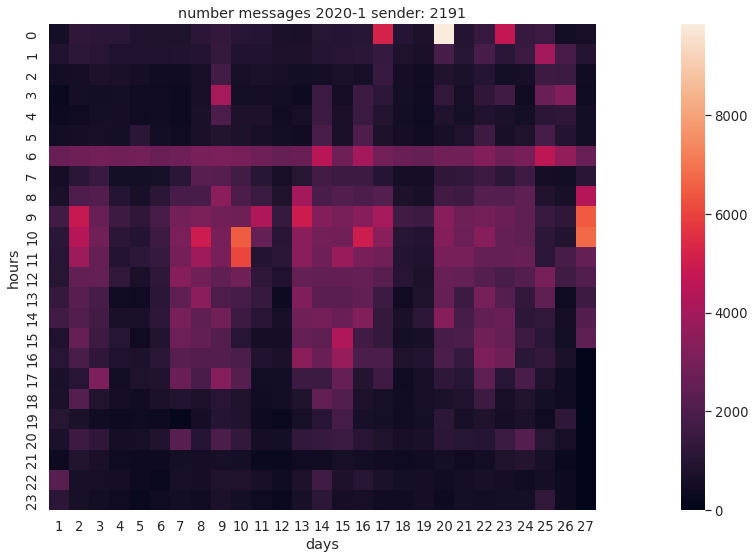

In [24]:
createHeatmapPfall(pfall1,str(sender),1)

In [30]:
pfall1 = pfall.sort_values(['year','month','day','hour']).reset_index()
del pfall1['index']
del pfall1['CGLOBALMESSAGEID']

In [32]:
del pfall1['index']
del pfall1['CGLOBALMESSAGEID']
pfall1

,CSTARTTIME,CENDTIME,CSTATUS,CSERVICE,CSENDERPROTOCOL,CSENDERENDPOINTID,CINBOUNDSIZE,CRECEIVERPROTOCOL,CRECEIVERENDPOINTID,CSLATAT,CMESSAGETAT2,CSLADELIVERYTIME,year,month,day,hour,minute,__index_level_0__
0,1572322183400,1572322188083,11,5,0,2191,7306,0,1533,4378,4683,1572322187778,2019,10,29,5,9,6432012
1,1572322185260,1572322189837,11,5,0,2191,79373,2,2257,4326,4577,1572322189586,2019,10,29,5,9,647905
2,1572322185466,1572322189744,11,5,0,2191,64555,2,2257,4051,4278,1572322189517,2019,10,29,5,9,326735
3,1572322216345,1572322222081,11,5,0,2191,7306,0,1533,5451,5736,1572322221796,2019,10,29,5,10,8819698
4,1572322217395,1572322224003,11,5,0,2191,79373,2,2257,6352,6608,1572322223747,2019,10,29,5,10,5282590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437034,1580137125808,1580137125934,9,5,0,2191,11492,5,1541,0,126,-1,2020,1,27,15,58,5369585
2437035,1580137125817,1580137127049,9,5,0,2191,448,5,1541,0,1232,-1,2020,1,27,15,58,5185914
2437036,1580137126438,1580137126936,9,5,0,2191,190,5,1541,0,498,-1,2020,1,27,15,58,780805
2437037,1580137127477,1580137127621,9,5,0,2191,454,5,1541,0,144,-1,2020,1,27,15,58,4772592


In [19]:
# using single sender
pfall1 = pfall 
pfall1

,CGLOBALMESSAGEID,CSTARTTIME,CENDTIME,CSTATUS,CSERVICE,CSENDERPROTOCOL,CSENDERENDPOINTID,CINBOUNDSIZE,CRECEIVERPROTOCOL,CRECEIVERENDPOINTID,CSLATAT,CMESSAGETAT2,CSLADELIVERYTIME,year,month,day,hour,minute,__index_level_0__
0,-6115189114597772327,1579063698184,1579063705174,11,6,0,998,196,3,1796,6900,6990,1579063705084,2020,1,15,5,48,0
1,6878249240966155692,1579063671345,1579063678840,11,5,0,9,2293,0,725,6159,7495,1579063677504,2020,1,15,5,47,1
2,-3549930604559515972,1579063697136,1579063704341,11,5,0,9,2293,0,725,6239,7205,1579063703375,2020,1,15,5,48,2
3,681232246707716600,1579063981014,1579063992051,11,6,4,1091,18649,0,1002,10875,11037,1579063991889,2020,1,15,5,53,3
4,5967495986884504656,1579064213256,1579064219980,11,5,0,2191,823,0,1533,6363,6724,1579064219619,2020,1,15,5,56,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9179759,7827078249242258575,1580136042805,1580136048602,11,5,0,2191,192,0,1533,5340,5797,1580136048145,2020,1,27,15,40,9181049
9179760,3130643920815826050,1580135822105,1580135832716,11,6,4,566,12816,0,290,10418,10611,1580135832523,2020,1,27,15,37,9181050
9179761,-5225696242936418752,1580135796226,1580135808490,11,6,4,2315,11520,0,601,12166,12264,1580135808392,2020,1,27,15,36,9181051
9179762,-1292871901319788194,1580136261792,1580136274606,11,1,9,963,3143,0,1470,6897,12814,1580136268689,2020,1,27,15,44,9181052


# Time Series Anomaly Detection with LSTM Autoencoders (selected sender)

In [33]:
import AnomalyDetectionLSTMAutoencoder
anomalyEnc = AnomalyDetectionLSTMAutoencoder.AnomalyDetectionLSTMAutoencoder()
anomalyEnc.initAndTrain(pfall1,0.94)
#anomalyEnc.__dict__

KeyError: 'outcome'

In [ ]:
#anomalyEnc.model.save("/tmp/my_model/",save_format="tf")
anomalyEnc.model.save("/tmp/mymodel.h5", save_format="h5")

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.6412632434878853, 0.12171660129414517)

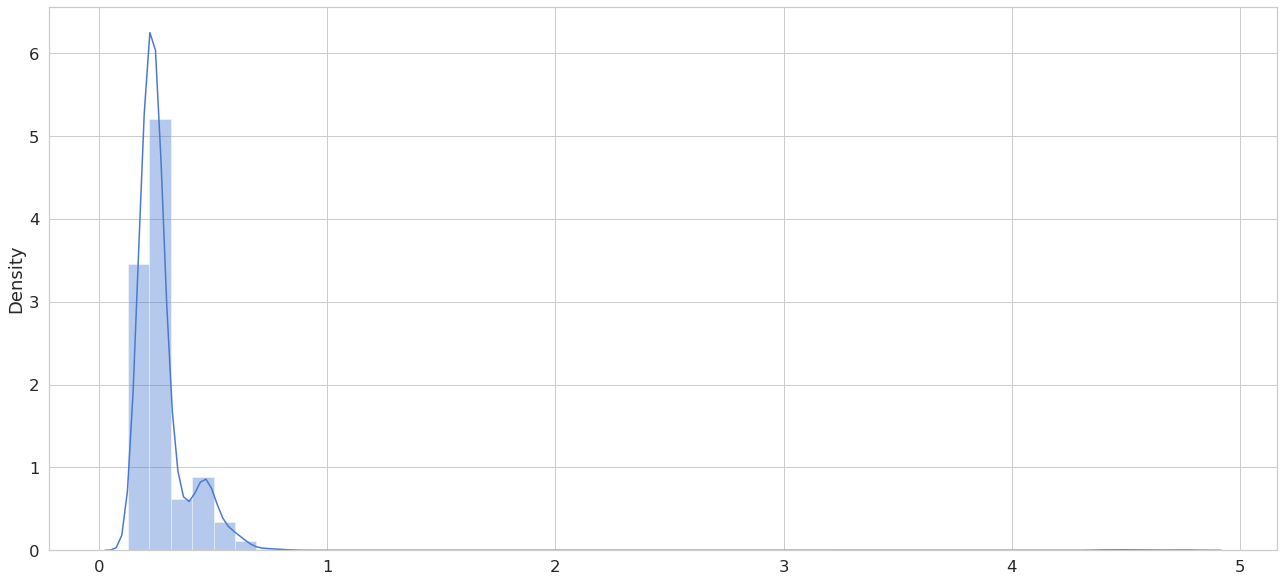

In [8]:
data = sns.distplot(anomalyEnc.train_mae_loss, bins=50, kde=True).get_lines()[0].get_data()
data[0][25], data[1][25]

In [9]:
anomalyEnc.evaluateAnomalies(data[0][25])

NameError: name 'test_score_df' is not defined

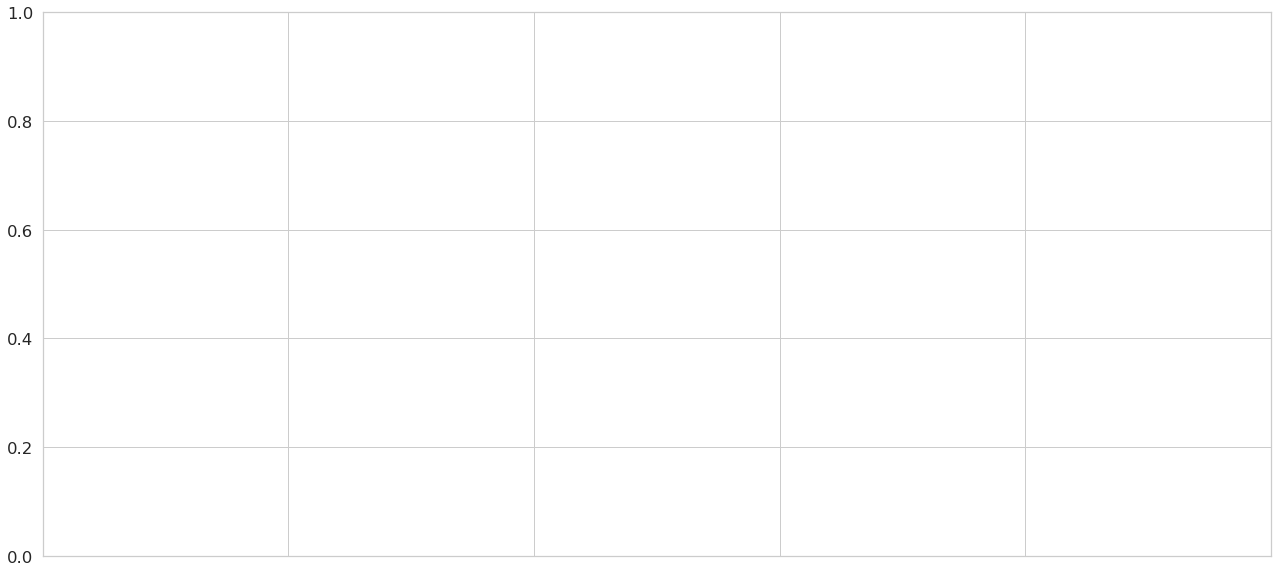

In [10]:
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
#plt.xticks(rotation=25)
#plt.legend();

In [11]:
sender = 0
titlestring ="endpoint (sending) : " + str(sender) + " ( trained: " +  anomalyEnc.train.index[0] + " -- " + anomalyEnc.train.index[len(anomalyEnc.train.index)-1] + " )"
anomaly.plot_test(anomalyEnc.test,anomalyEnc.scaler,anomalies,titlestring)

NameError: name 'anomalies' is not defined

# old

In [ ]:
import os
os.environ['http_proxy'] = "http://172.30.12.56:3128" 
os.environ['https_proxy'] = "https://172.30.12.56:3128" 
#!pip install --trusted-host pypi.python.org pytest-xdist
#!pip install --trusted-host pypi.python.org --upgrade pip
#!pip install --trusted-host pypi.python.org tensorflow
#!pip3 install --user --upgrade tensorflow 
#!pip install tensorflow==2.4.1
#!pip install --trusted-host pypi.python.org python==3.7
#!pip install --upgrade pip --trusted-host pypi.org --trusted-host files.pythonhosted.org
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org tensorflow==2.4.1

In [ ]:
import anomaly
anomaly.init_sns()
#pip3 install --trusted-host pypi.org --trusted-host files.pythonhosted.org numpy==1.18.5

In [ ]:
df1 = anomaly.createDataframe(pfall)
perc_train=0.94
train, test = anomaly.getTrainAndTest(df1,perc_train)
OUTCOME = 'close'
scaler = anomaly.StandardScaler()
scaler = scaler.fit(train[[OUTCOME]])
train[OUTCOME] = scaler.transform(train[[OUTCOME]])
test[OUTCOME] = scaler.transform(test[[OUTCOME]])

In [ ]:
TIME_STEPS = 12
X_train, y_train = anomaly.create_dataset(train[[OUTCOME]], train.close, TIME_STEPS)
X_test, y_test = anomaly.create_dataset(test[[OUTCOME]], test.close, TIME_STEPS)
print(X_train.shape)

In [ ]:
!pip install -U numpy==1.18.5

In [ ]:
#model = anomaly.initmodel(X_train)

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(256, input_shape=(1, 66), return_sequences=True))

model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
 
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [ ]:
model,scaler,train,test,X_test,X_train,X_train_pred,train_mae_loss = anomaly.initAndTrain(pfall1,0.94)

In [ ]:
data = sns.distplot(train_mae_loss, bins=50, kde=True).get_lines()[0].get_data()

In [ ]:
data[0][25], data[1][25]

In [ ]:
test_score_df = anomaly.testScoreDF(model, 0.65,X_test,test)
anomalies     = test_score_df[test_score_df.anomaly == True]

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
sender = 0
titlestring ="endpoint (sending) : " + str(sender) + " ( trained: " +  train.index[0] + " -- " + train.index[len(train.index)-1] + " )"
anomaly.plot_test(test,scaler,anomalies,titlestring)